In [1]:
import os
import pathlib

p_project = str(pathlib.Path(os.getcwd()).parents[1])

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import numpy as np

In [3]:
adm=pd.read_csv(p_project + "/data/mimic3/ADMISSIONS.csv.gz", compression='gzip')
adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
#Load the patients data base and add the Date of birth to the admission dataset.
patients_df=pd.read_csv(p_project + "/data/mimic3/PATIENTS.csv.gz", compression='gzip')
patients_df["DOBTIME"]=pd.to_datetime(patients_df["DOB"], format='%Y-%m-%d')
patients_df[["SUBJECT_ID","DOBTIME"]].head()
adm_dob=pd.merge(patients_df[["SUBJECT_ID","DOBTIME"]],adm,on="SUBJECT_ID")

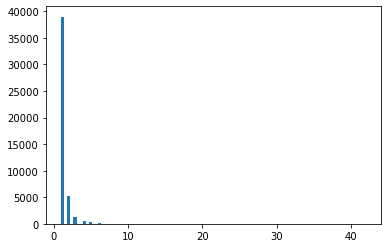

Number of patients with specific number of admissions : 
 1     38983
2      5160
3      1342
4       508
5       246
6       113
7        51
8        31
9        26
10       14
11       13
12        8
13        5
14        4
17        3
16        2
34        2
31        1
21        1
22        1
19        1
42        1
23        1
24        1
20        1
15        1
Name: HADM_ID, dtype: int64


In [5]:
#Number of admissions by patient
df=adm.groupby("SUBJECT_ID")["HADM_ID"].nunique()
plt.hist(df,bins=100)
plt.show()
print("Number of patients with specific number of admissions : \n",df.value_counts())

As the majortity of patients only present a single admission, we filter out all the patients with more than 1 admission

In [6]:
subj_ids=list(df[df==1].index) #index of patients with only one visit.
adm_1=adm_dob.loc[adm_dob["SUBJECT_ID"].isin(subj_ids)] #filter out the patients with more than one visit
print("Number of patients remaining in the dataframe: ")
print(len(adm_1.index))

Number of patients remaining in the dataframe: 
38983


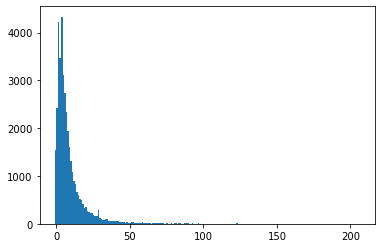

Number of patients with specific duration of admissions in days : 
 4      4333
2      4216
3      3478
5      3119
6      2739
       ... 
181       1
128       1
202       1
151       1
206       1
Name: ELAPSED_DAYS, Length: 156, dtype: int64


In [7]:
#We now add a new column with the duration of each stay.
adm_1=adm_1.copy()
adm_1['ADMITTIME']=pd.to_datetime(adm_1["ADMITTIME"], format='%Y-%m-%d %H:%M:%S')
adm_1['DISCHTIME']=pd.to_datetime(adm_1["DISCHTIME"], format='%Y-%m-%d %H:%M:%S')

adm_1["ELAPSED_TIME"]=adm_1["DISCHTIME"]-adm_1["ADMITTIME"]
adm_1.head()
adm_1["ELAPSED_DAYS"]=adm_1["ELAPSED_TIME"].dt.days #Elapsed time in days in ICU
plt.hist(adm_1["ELAPSED_DAYS"], bins=200)
plt.show()
print("Number of patients with specific duration of admissions in days : \n",adm_1["ELAPSED_DAYS"].value_counts())

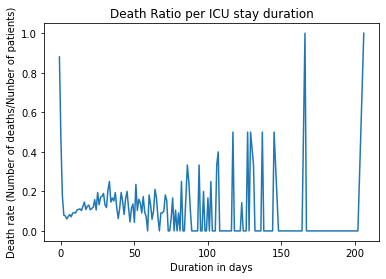

In [8]:
#Let's now report the death rate in function of the duration stay in ICU.
adm_1["DEATHTAG"]=0
adm_1.loc[adm_1.DEATHTIME.notnull(),"DEATHTAG"]=1

df_deaths_per_duration=adm_1.groupby("ELAPSED_DAYS")["DEATHTAG"].sum()
df_patients_per_duration=adm_1.groupby("ELAPSED_DAYS")["SUBJECT_ID"].nunique()
df_death_ratio_per_duration=df_deaths_per_duration/df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

Given the results above, we select patients with a least 48 hours in the ICU and with less than 30 days stay.

In [9]:
adm_2=adm_1.loc[(adm_1["ELAPSED_DAYS"]<30) & (adm_1["ELAPSED_DAYS"]>2)]
print("Number of patients remaining in the dataframe: ")
print(len(adm_2.index))

Number of patients remaining in the dataframe: 
28840


We remove the patients who are younger than 15 at admission time

In [ ]:
adm_2['ADMITTIME'] = adm_2['ADMITTIME'].dt.date
adm_2['DOBTIME'] = adm_2['DOBTIME'].dt.date
adm_2['age'] = adm_2.apply(lambda e: (e['ADMITTIME'] - e['DOBTIME']).days/365, axis=1)

In [22]:
adm_2_15=adm_2.loc[adm_2['age'] > 15].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_15.index))

Number of patients remaining in the dataframe: 
24721


We remove the admissions with no chart events data.

In [23]:
adm_2_15_chart=adm_2_15.loc[adm_2_15["HAS_CHARTEVENTS_DATA"]==1].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_15_chart.index))

Number of patients remaining in the dataframe: 
24689


In [24]:
#We now investigate the admission_type
df_type=adm_2_15_chart.groupby("ADMISSION_TYPE")["SUBJECT_ID"].count()
df_type

ADMISSION_TYPE
ELECTIVE      4633
EMERGENCY    19334
URGENT         722
Name: SUBJECT_ID, dtype: int64

We remove the newborns as they are specific

In [26]:
adm_3=adm_2_15_chart.loc[adm_2_15_chart["ADMISSION_TYPE"]!="NEWBORN"]
print("Number of patients remaining in the dataframe: ")
print(adm_3["SUBJECT_ID"].nunique())

adm_3.to_csv(p_project + "/data/mimic3/processed/admissions_processed.csv")

Number of patients remaining in the dataframe: 
24689
